### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('Time_series_analysis_and_forecast_DATASET.csv')

In [3]:
df['FullDate'] = pd.to_datetime(df['FullDate'])
df.set_index('FullDate', inplace=True)
df.head()

,Tmax,SysLoad,GasPrice,ElecPrice
FullDate,,,,
2010-09-01 00:00:00,15.8,1688.215,3.69,23.710
2010-09-01 01:00:00,15.8,1669.195,3.69,22.635
2010-09-01 02:00:00,15.8,1491.980,3.69,22.565
2010-09-01 03:00:00,15.8,1330.760,3.69,18.910
2010-09-01 04:00:00,15.8,1247.940,3.69,18.030


In [4]:
# Checking missing values 
df.isna().sum()

Tmax         0
SysLoad      0
GasPrice     0
ElecPrice    0
dtype: int64

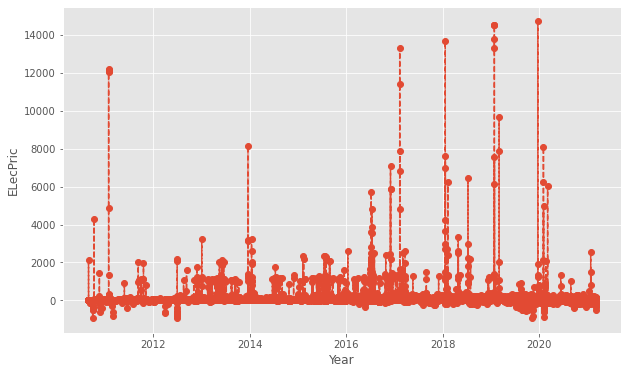

In [5]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['ElecPrice'], '--', marker='o')
# plt.grid()
plt.xlabel('Year')
plt.ylabel('ELecPric')
plt.show()

In [6]:
# Resampling
daily_df = df.resample('D').sum()

In [7]:
daily_df.reset_index(inplace=True)
daily_df.head()

,FullDate,Tmax,SysLoad,GasPrice,ElecPrice
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


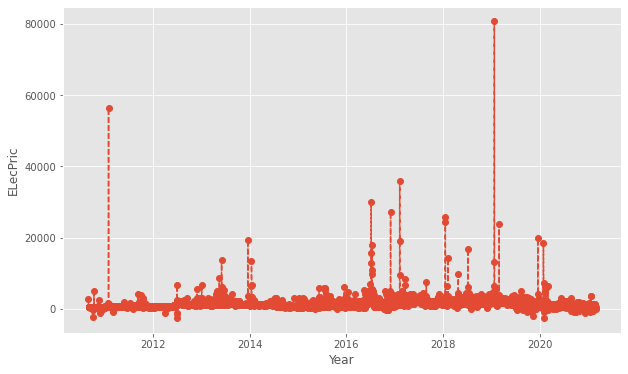

In [8]:
plt.figure(figsize=(10,6))
plt.plot(daily_df['FullDate'], daily_df['ElecPrice'], '--', marker='o')
# plt.grid()
plt.xlabel('Year')
plt.ylabel('ELecPric')
plt.show()

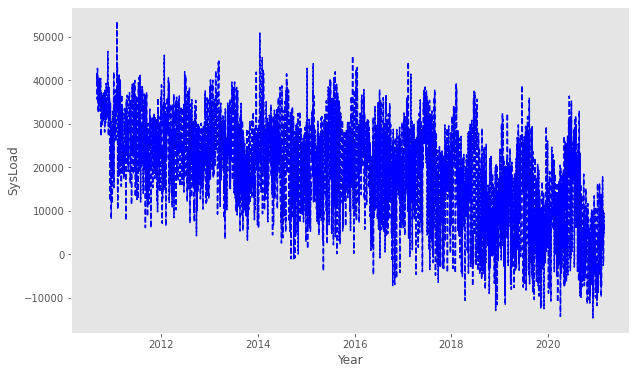

In [9]:
plt.figure(figsize=(10,6))
plt.plot(daily_df['FullDate'], daily_df['SysLoad'], '--', c='blue')
plt.grid()
plt.xlabel('Year')
plt.ylabel('SysLoad')
plt.show()

### Augmented Dickey-Fuller test (ADF)

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_results(col):
    adf_result = adfuller(col)
    print(f'ADF Statistics: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}')
    print(f'No. of lags used: {adf_result[2]}')
    print(f'No. of observations used: {adf_result[3]}')
    print('Critical Values')
    for k,v in adf_result[4].items():
        print(f'  {k}: {v}')
    if adf_result[1] < 0.05:
        print(f'Reject Null Hypothesis. The Time Series is Stationary.') 

In [11]:
adf_results(daily_df['Tmax'])

ADF Statistics: -20.766001357159368
p-value: 0.0
No. of lags used: 6
No. of observations used: 3827
Critical Values
  1%: -3.4320598750004825
  5%: -2.862295528895607
  10%: -2.567172177683642
Reject Null Hypothesis. The Time Series is Stationary.


In [12]:
adf_results(daily_df['SysLoad'])

ADF Statistics: -3.690158988836651
p-value: 0.00425372550457405
No. of lags used: 30
No. of observations used: 3803
Critical Values
  1%: -3.432070672988693
  5%: -2.8623002987378547
  10%: -2.567174716967499
Reject Null Hypothesis. The Time Series is Stationary.


In [13]:
adf_results(daily_df['GasPrice'])

ADF Statistics: -2.902766697165178
p-value: 0.04502721288462563
No. of lags used: 27
No. of observations used: 3806
Critical Values
  1%: -3.4320693157877544
  5%: -2.8622996992165364
  10%: -2.5671743978048323
Reject Null Hypothesis. The Time Series is Stationary.


In [14]:
adf_results(daily_df['ElecPrice'])

ADF Statistics: -8.269053866873824
p-value: 4.848817773711018e-13
No. of lags used: 20
No. of observations used: 3813
Critical Values
  1%: -3.432066157296446
  5%: -2.8622983040036005
  10%: -2.5671736550459663
Reject Null Hypothesis. The Time Series is Stationary.


In [15]:
train_df = daily_df[:2757]
test_df = daily_df[2757:]

In [16]:
uni_train = train_df[['FullDate', 'ElecPrice']].copy()
uni_test = test_df[['FullDate', 'ElecPrice']].copy()
uni_train.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'}, inplace=True)
uni_test.rename(columns={'FullDate': 'ds', 'ElecPrice': 'y'}, inplace=True)


In [17]:
from prophet import Prophet
model = Prophet()
model.fit(uni_train)
future = model.make_future_dataframe(periods=len(uni_test), freq='D')
forecast = model.predict(future)

01:05:46 - cmdstanpy - INFO - Chain [1] start processing
01:05:47 - cmdstanpy - INFO - Chain [1] done processing


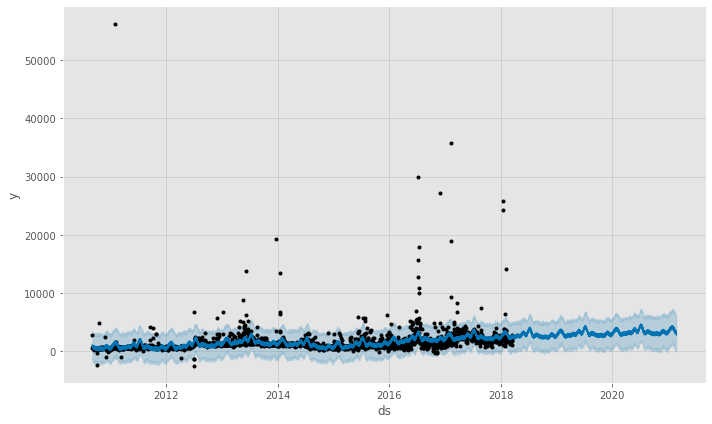

In [18]:
model.plot(forecast)
plt.show()

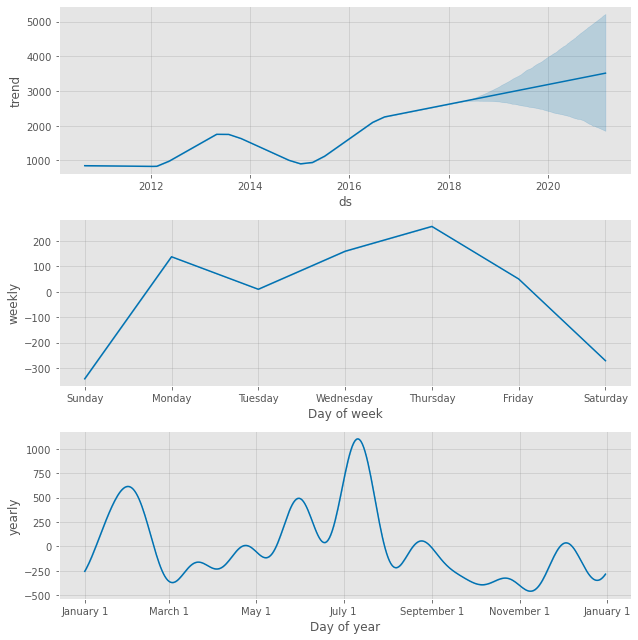

In [19]:
model.plot_components(forecast)
plt.show()

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

In [21]:
def MAPE(y, y_hat):
    return np.mean(np.abs((y - y_hat)/y)) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

In [22]:
print(MAPE(uni_test['y'], forecast['yhat']))
print(RMSE(uni_test['y'], forecast['yhat']))

540.8215054992062
3200.059470484568


In [23]:
mul_df = daily_df.copy()
mul_df.rename(columns={'FullDate': 'ds', 'Tmax': 'add1', 'SysLoad': 'add2',	'GasPrice': 'add3',	'ElecPrice': 'y'},inplace=True)
mul_df.head()

,ds,add1,add2,add3,y
0,2010-09-01,379.2,41565.380,88.56,2751.700
1,2010-09-02,369.6,38898.990,88.56,570.810
2,2010-09-03,439.2,41665.760,106.80,504.975
3,2010-09-04,328.8,35638.085,81.36,502.275
4,2010-09-05,357.6,35611.410,106.80,500.555


In [24]:
mul_train = mul_df[:2757]
mul_test= mul_df[2757:]

In [25]:
n_model = Prophet()
n_model.add_regressor('add1')
n_model.add_regressor('add2')
n_model.add_regressor('add3')
n_model.fit(mul_train)
future = model.make_future_dataframe(periods=len(mul_test), freq='D')
future['add1'] = mul_df['add1']
future['add2'] = mul_df['add2']
future['add3'] = mul_df['add3']
n_forecast = n_model.predict(future)

01:05:53 - cmdstanpy - INFO - Chain [1] start processing
01:05:54 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
print(MAPE(mul_test['y'], n_forecast['yhat']))
print(RMSE(mul_test['y'], n_forecast['yhat']))

236.59911725941188
2712.7221470743652


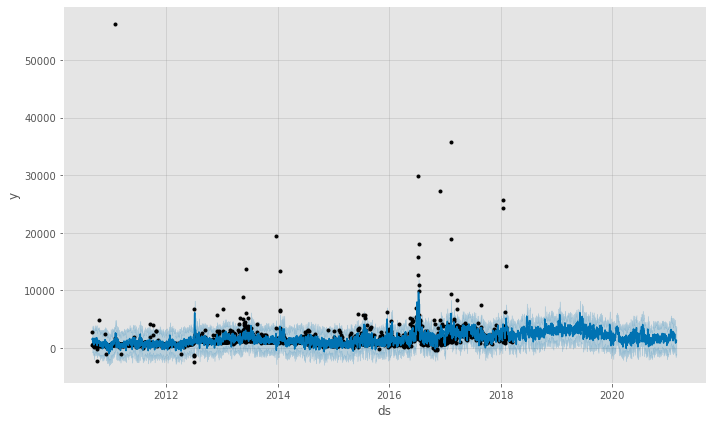

In [27]:
n_model.plot(n_forecast)
plt.show()

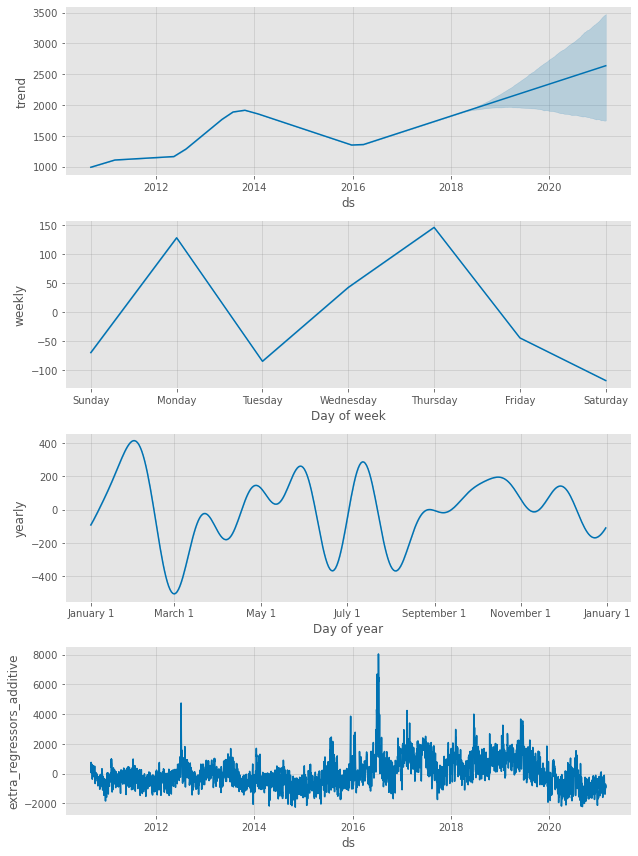

In [28]:
n_model.plot_components(n_forecast)
plt.show()

### Dropping T-max

In [29]:
new_train = mul_train.drop(columns='add1')
new_test = mul_test.drop(columns='add1')

In [30]:
n_model = Prophet()
n_model.add_regressor('add2')
n_model.add_regressor('add3')
n_model.fit(new_train)
future = model.make_future_dataframe(periods=len(new_test), freq='D')
future['add2'] = mul_df['add2']
future['add3'] = mul_df['add3']
n_forecast = n_model.predict(future)

01:05:59 - cmdstanpy - INFO - Chain [1] start processing
01:05:59 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
print(MAPE(uni_test['y'], n_forecast['yhat']))
print(RMSE(uni_test['y'], n_forecast['yhat']))

230.09819426242558
2705.782380380505
